In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import re

## Loading the Data

In [2]:
#Directory for Dataset
data_dir = os.getcwd()+'\dataset'

In [3]:
df = pd.read_csv(data_dir+'\\airline_sentiment_analysis.csv', encoding="ISO-8859-1")

In [4]:
df.head(2)

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...


In [5]:
import matplotlib.pyplot as plt

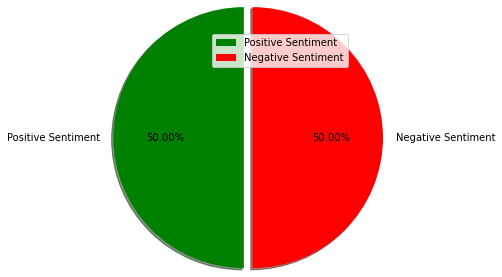

In [6]:
sentiments = ['Positive Sentiment', 'Negative Sentiment'] 
slices = [(df['airline_sentiment'] != "positive").sum(), (df['airline_sentiment'] == 'negative').sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

## Data Preprocessing

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
class Process_Text:
    
    tokenizer = Tokenizer(num_words=1500, split=' ')
        
    def __init__(self,input_text):
        self.input_text = input_text
        
    def process_text(self):               
        self.input_text = np.vectorize(self.remove_unwanted)(self.input_text)
        
        self.tokenizer.fit_on_texts(self.input_text)
                
        #Tokenize the text
        return(self.tokenize(self.input_text))
        
    def emoji(self,text):

        # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
        text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', text)
        # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
        text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', text)
        # Love -- <3, :*
        text = re.sub(r'(<3|:\*)', ' positiveemoji ', text)
        # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
        text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', text)
        # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
        text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', text)
        # Cry -- :,(, :'(, :"(
        text = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', text)

        return text            
                    
    def remove_unwanted(self,text):
        text = text.lower()                                             # Lowercases the string
        text = re.sub('@[^\s]+', '', text)                              # Removes usernames
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Remove URLs
        text = re.sub(r"\d+", " ", str(text))                           # Removes all digits
        text = re.sub('&quot;'," ", text)                               # Remove (&quot;) 
        text = self.emoji(text)                                         # Replaces Emojis
        text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Removes all single characters
        text = re.sub(r"[^\w\s]", " ", str(text))                       # Removes all punctuations
        text = re.sub(r'(.)\1+', r'\1\1', text)                         # Convert more than 2 letter repetitions to 2 letter
        text = re.sub(r"\s+", " ", str(text))                           # Replaces double spaces with single space    
        return text
    
    def tokenize(self,text):

        try:
            text = self.tokenizer.texts_to_sequences(text)
            text = pad_sequences(text)

        except:
            pass 
        
        finally:
            return text
        
        

In [9]:
pr  =  Process_Text(df['text'])

#Processing the text
X   = pr.process_text()

#Encoding values for Labels (Positive:1 , Negative : 0)
y = df['airline_sentiment'].replace({'positive':1,'negative':0})

## Train Test Split

In [10]:
from sklearn.model_selection import train_test_split 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

# Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM,Bidirectional, Dropout

In [13]:
class Model:
    
    model   = None
    max_len = None

    def __init__(self,embed_dim,input_length,lstm_out):
        
        self.model = Sequential()
        self.max_len = input_length
        
        #Embedding
        self.model.add(Embedding(1500, embed_dim,input_length = input_length))

        #LSTM
        self.model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))

        #DENSE
        self.model.add(Dense(2,activation='relu'))
        
        #DENSE
        self.model.add(Dense(1,activation='sigmoid'))

        self.model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
        
    def train(self,epochs,X,y,validation_data,batch_size):     
        self.model.fit(X, y,validation_data =validation_data,epochs = epochs, batch_size=batch_size)
        
    
    def predict(self,test_text):        
        return(np.round(self.model.predict_classes(test_text)))
    
    
    def save_model(self):
        self.model.save("LSTM")
              

In [14]:
embed_dim = 128
lstm_out = 196
max_length  = max([len(x) for x in X])

model = Model(embed_dim, max_length,lstm_out)
model.train(X = X_train, y = y_train,validation_data = (X_test,y_test),epochs = 15, batch_size=32)

Epoch 1/15
307/307 [==============================] - 32s 104ms/step - loss: 0.3438 - accuracy: 0.8552 - val_loss: 0.2576 - val_accuracy: 0.9261
Epoch 2/15
307/307 [==============================] - 31s 101ms/step - loss: 0.2385 - accuracy: 0.9258 - val_loss: 0.2855 - val_accuracy: 0.8967
Epoch 3/15
307/307 [==============================] - 31s 101ms/step - loss: 0.1971 - accuracy: 0.9400 - val_loss: 0.2436 - val_accuracy: 0.9186
Epoch 4/15
307/307 [==============================] - 33s 108ms/step - loss: 0.1740 - accuracy: 0.9462 - val_loss: 0.2418 - val_accuracy: 0.9180
Epoch 5/15
307/307 [==============================] - 28s 90ms/step - loss: 0.1494 - accuracy: 0.9531 - val_loss: 0.2623 - val_accuracy: 0.9105
Epoch 6/15
307/307 [==============================] - 28s 91ms/step - loss: 0.1322 - accuracy: 0.9598 - val_loss: 0.2796 - val_accuracy: 0.9203
Epoch 7/15
307/307 [==============================] - 29s 95ms/step - loss: 0.1182 - accuracy: 0.9641 - val_loss: 0.3113 - val_accur

## Saving the Model and Tokenizer

In [15]:
model.save_model()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: LSTM\assets


In [16]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(pr.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Metrics

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
#X_test = pr.tokenize(X_test)
preds  = model.predict(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


## Confusion Matrix

In [19]:
con_matrix = confusion_matrix(y_test,preds)

In [20]:
import seaborn as sns

<AxesSubplot:>

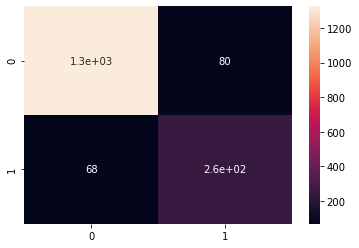

In [21]:
sns.heatmap(con_matrix,annot=True)

## Classification Report

In [22]:
class_report = pd.DataFrame(classification_report(y_test,preds,output_dict=True)).transpose()

In [23]:
class_report

,precision,recall,f1-score,support
0,0.951184,0.943060,0.947105,1405.00000
1,0.764012,0.792049,0.777778,327.00000
accuracy,0.914550,0.914550,0.914550,0.91455
macro avg,0.857598,0.867555,0.862441,1732.00000
weighted avg,0.915846,0.914550,0.915136,1732.00000


## Testing

In [24]:
test_text = ['I hate this movie']
#test_text = pr.tokenize(test_text) 

test_text  = tokenizer.texts_to_sequences(test_text)
test_text =  pad_sequences(test_text,maxlen=49)

In [25]:
preds_dict = {0:"Negative",1:"Positive"}

preds_dict[model.predict(test_text)[0][0]]

'Negative'